In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import warnings
warnings.filterwarnings("ignore")

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, train_test_split, cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
import optuna
from optuna.samplers import TPESampler

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/reservation-cancellation-prediction/train__dataset.csv
/kaggle/input/reservation-cancellation-prediction/test___dataset.csv
/kaggle/input/playground-series-s3e7/sample_submission.csv
/kaggle/input/playground-series-s3e7/train.csv
/kaggle/input/playground-series-s3e7/test.csv


# 1. Setup

In [2]:
concat = True # To use original dataset or no 
FEATURE_ENGINEERING = True # Whether to introduce new engineered features
TUNE = False # Will take an extremely long time
RANDOM = 42
BASIC = False # Whether to use basic hyperparameter or use the tuned ones

# 2. Data

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s3e7/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e7/test.csv')
sub = pd.read_csv('/kaggle/input/playground-series-s3e7/sample_submission.csv')
original = pd.read_csv('/kaggle/input/reservation-cancellation-prediction/train__dataset.csv')

In [4]:
train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

#### Utilizing the original dataset will increase our training data and possibly lead to more accurate results

In [5]:
if concat:
    total_train = pd.concat([train, original])
    total_train.drop_duplicates(inplace=True)

#### Let us define our feature and target variables

In [6]:
features = list(total_train.columns[:-1])
target = 'booking_status'

## 2.1 Visualization

#### Let's observe both train and test dataset to see whether there are any outrageous outliers that may negatively affect our model's performance

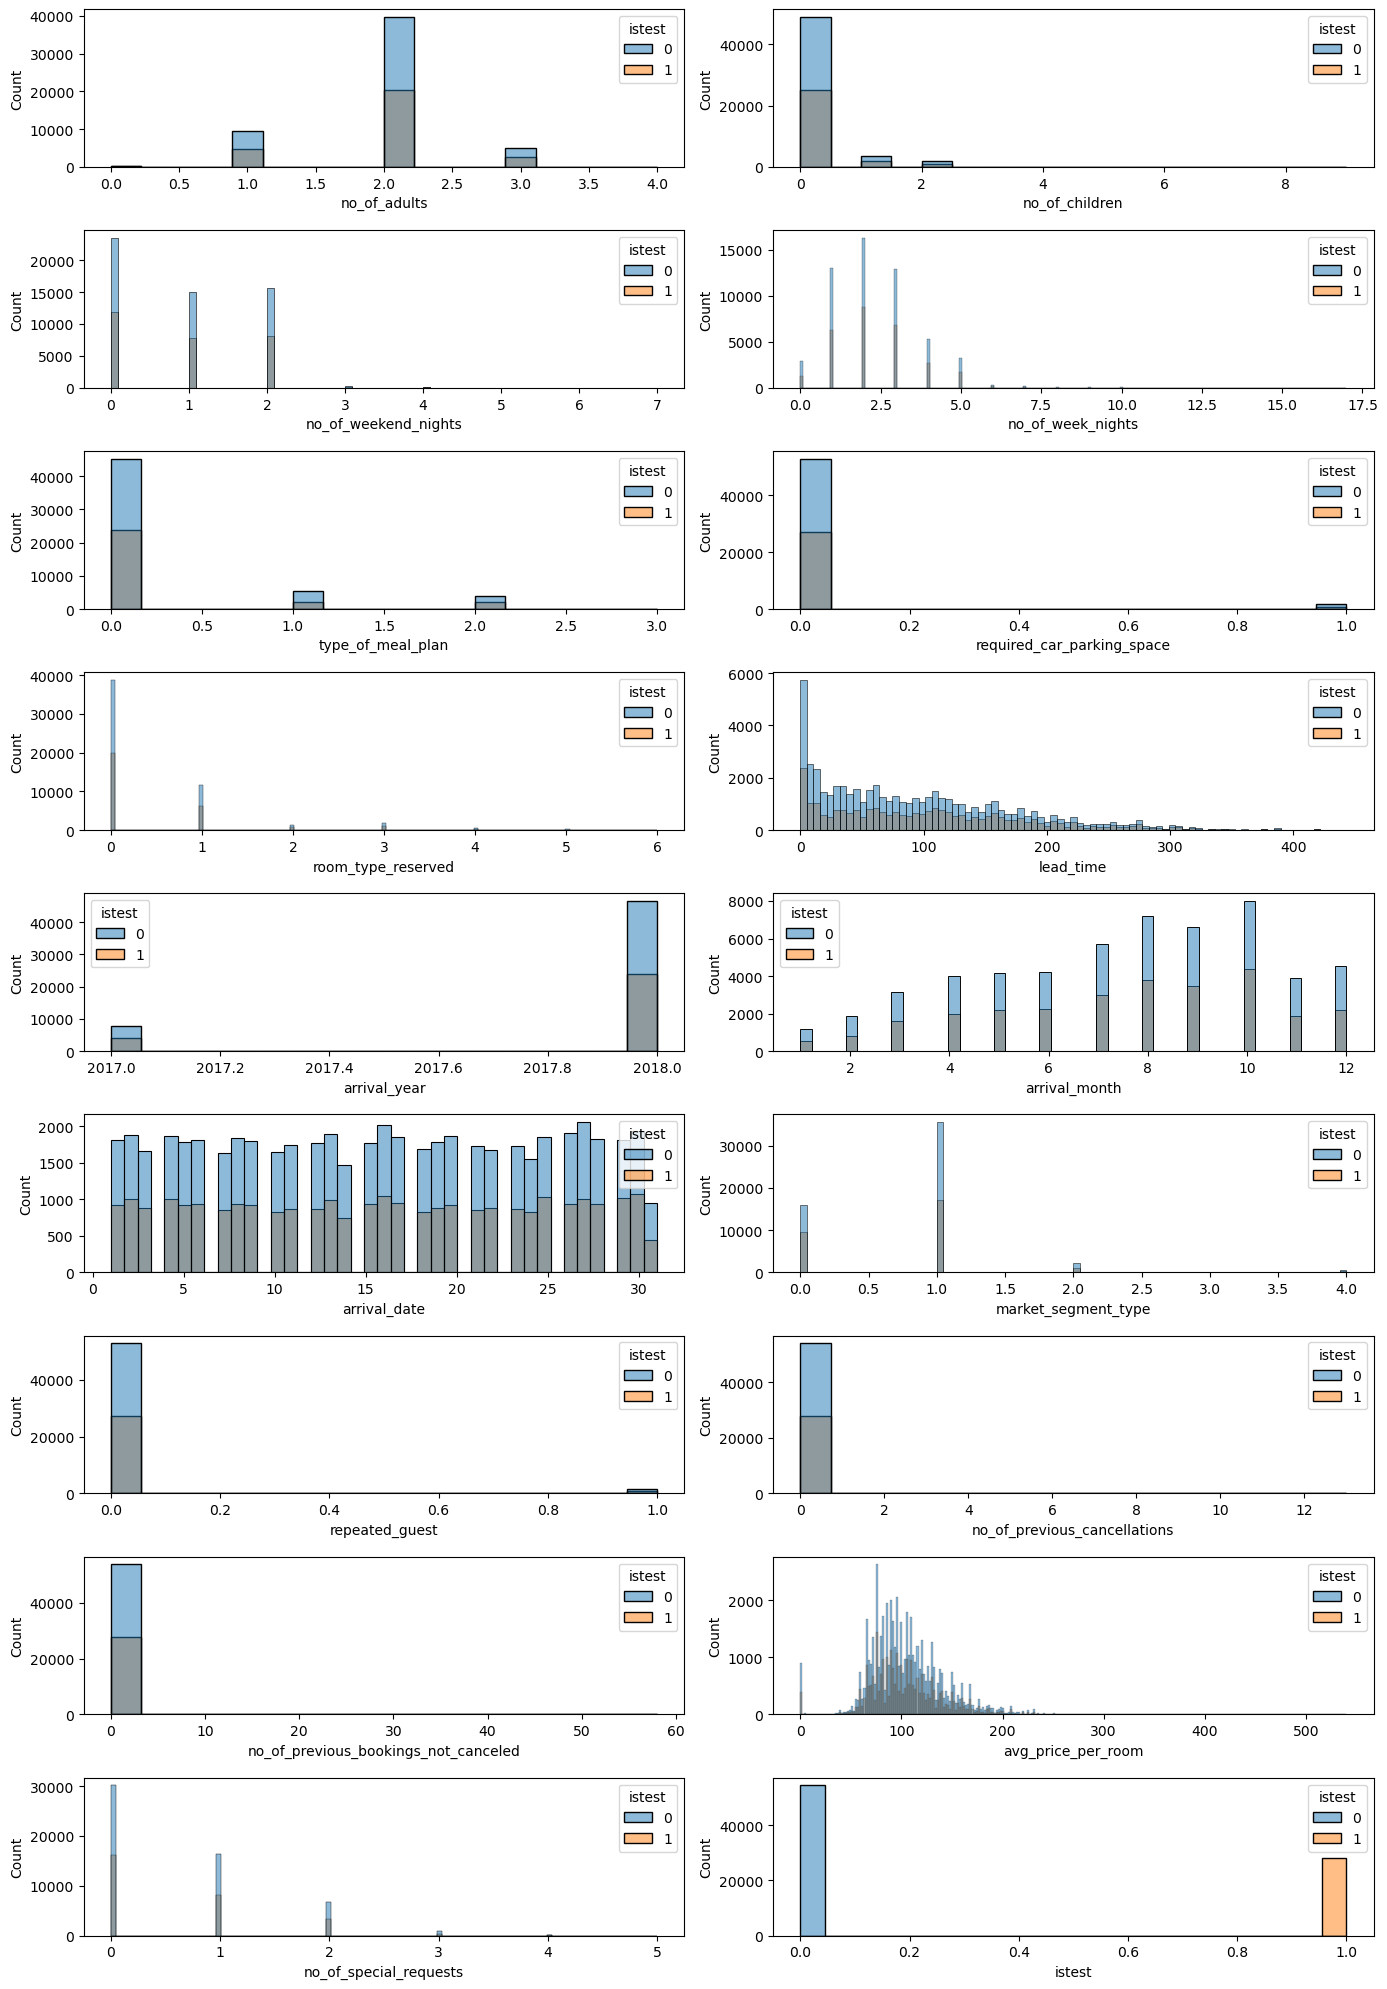

In [7]:
fig, axs = plt.subplots(9, 2, figsize=(14,20))
total_train['istest'] = 0
test['istest'] = 1
features.extend(['istest'])
raw = pd.concat([total_train, test])
raw.reset_index(inplace=True)
for i in range(9):
    for j in range(2):
        sns.histplot(raw[features], x = features[i*2+j], hue='istest', ax=axs[i][j])
features.remove('istest')
plt.tight_layout()
plt.show()

#### Let's take a look at the test dataset itself

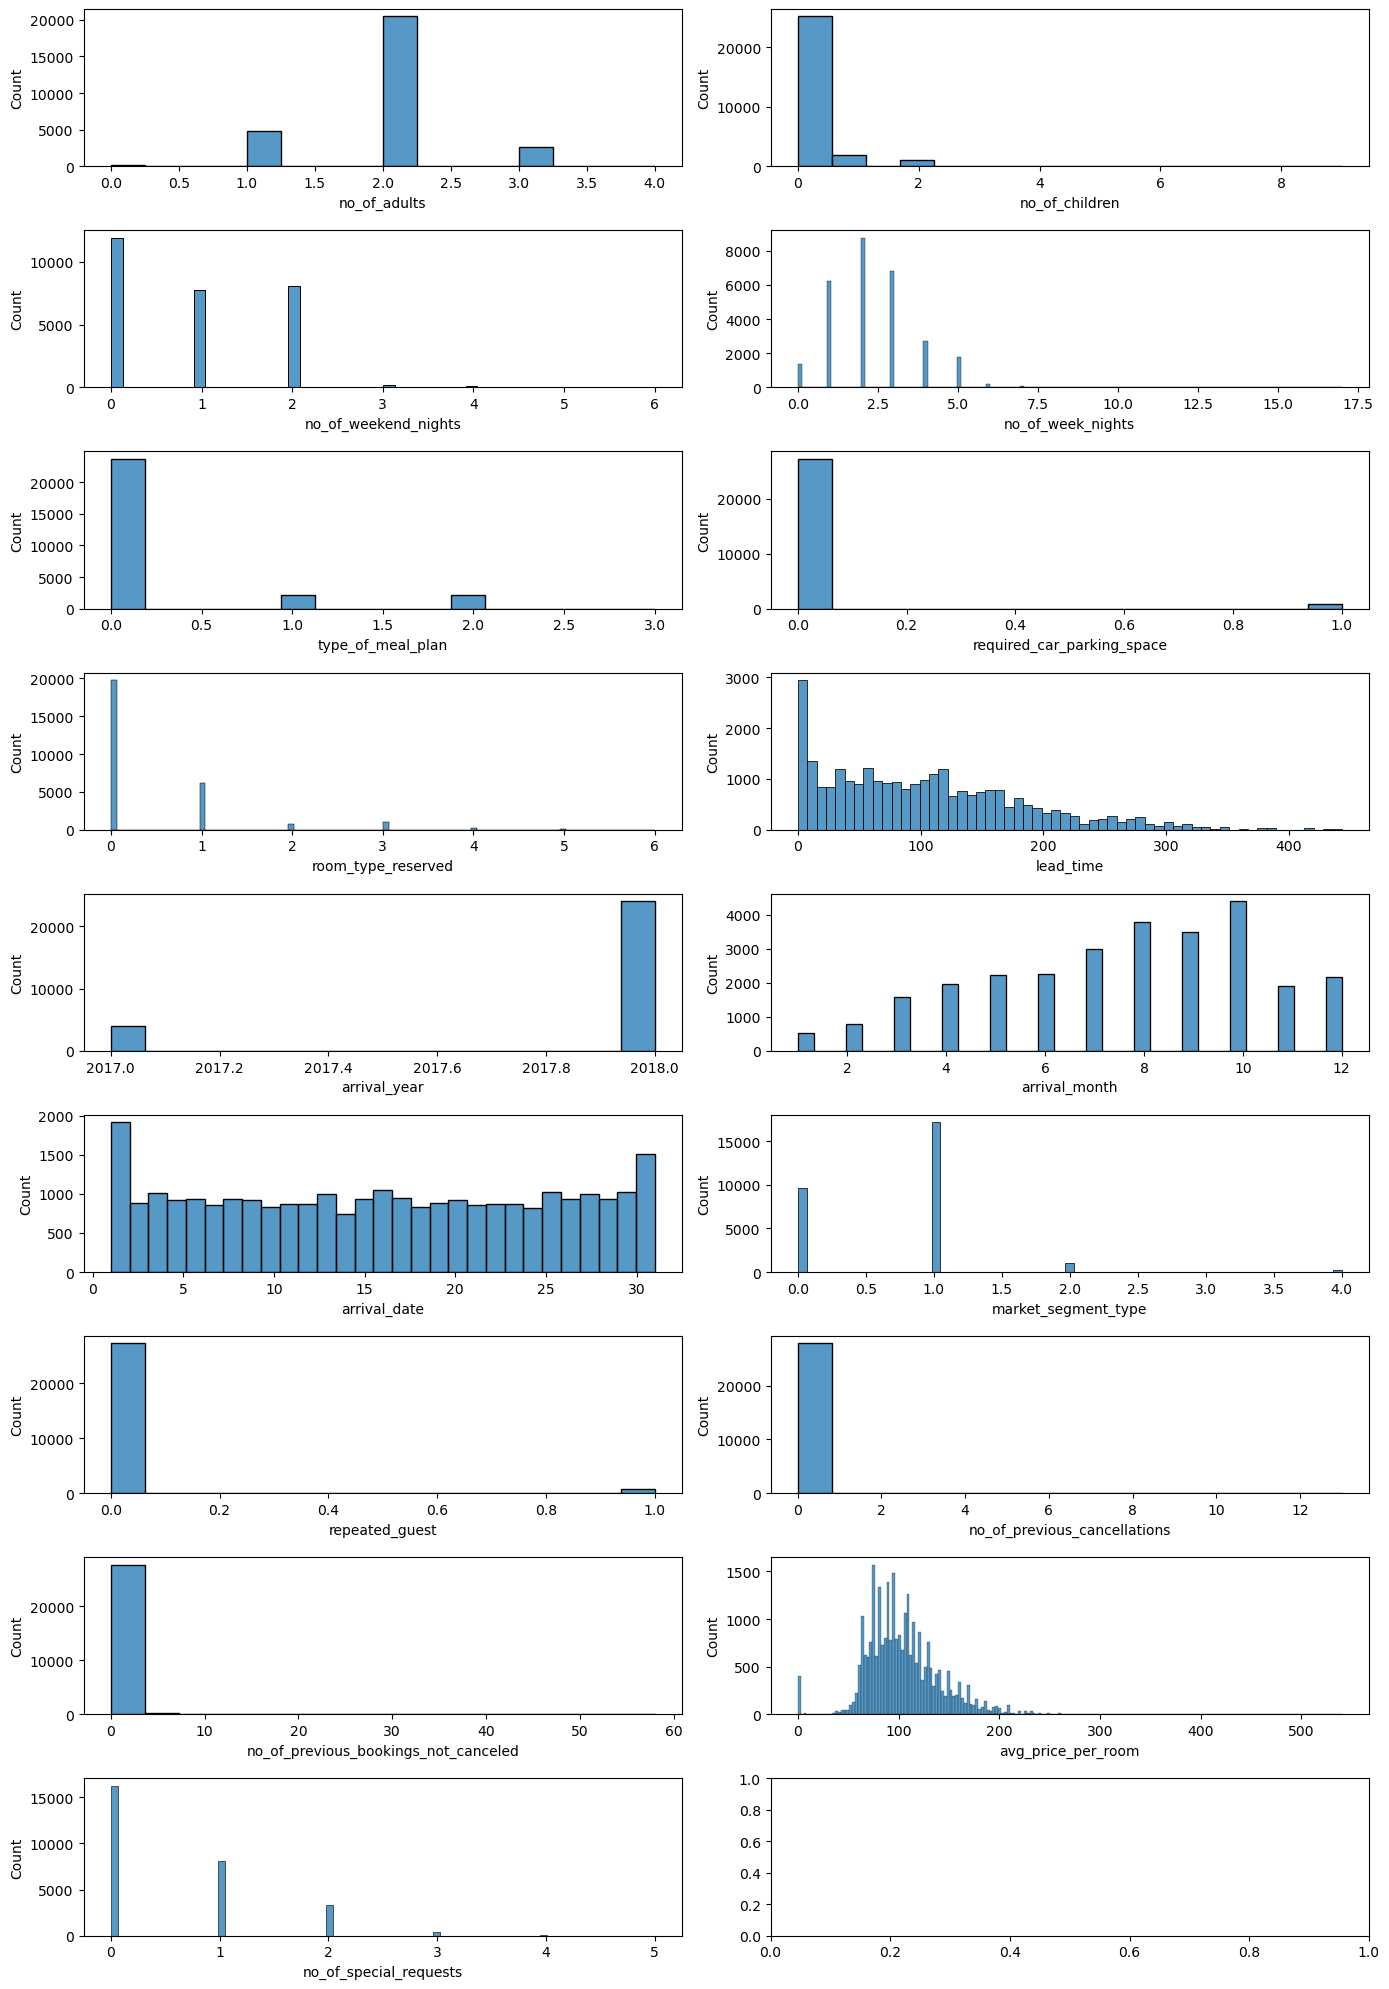

In [8]:
fig, axs = plt.subplots(9, 2, figsize=(14,20))
raw = test
for i in range(9):
    for j in range(2):
        if (i*2+j) == 17:
            continue
        sns.histplot(raw[features], x = features[i*2+j], ax=axs[i][j])
plt.tight_layout()
plt.show()

#### From a closer look at the test dataset, we can conclude that there aren't extreme outliers in the training dataset that we would need to eliminate
#### If I saw any significant outliers, I was thinking of employing the IQR method to spot out outliers that lie beyond the ranges
#### However, in this case, the features are mostly categorical variables and for the continuous variables, they do not differ much from the test dataset

## 2.2 Correlations

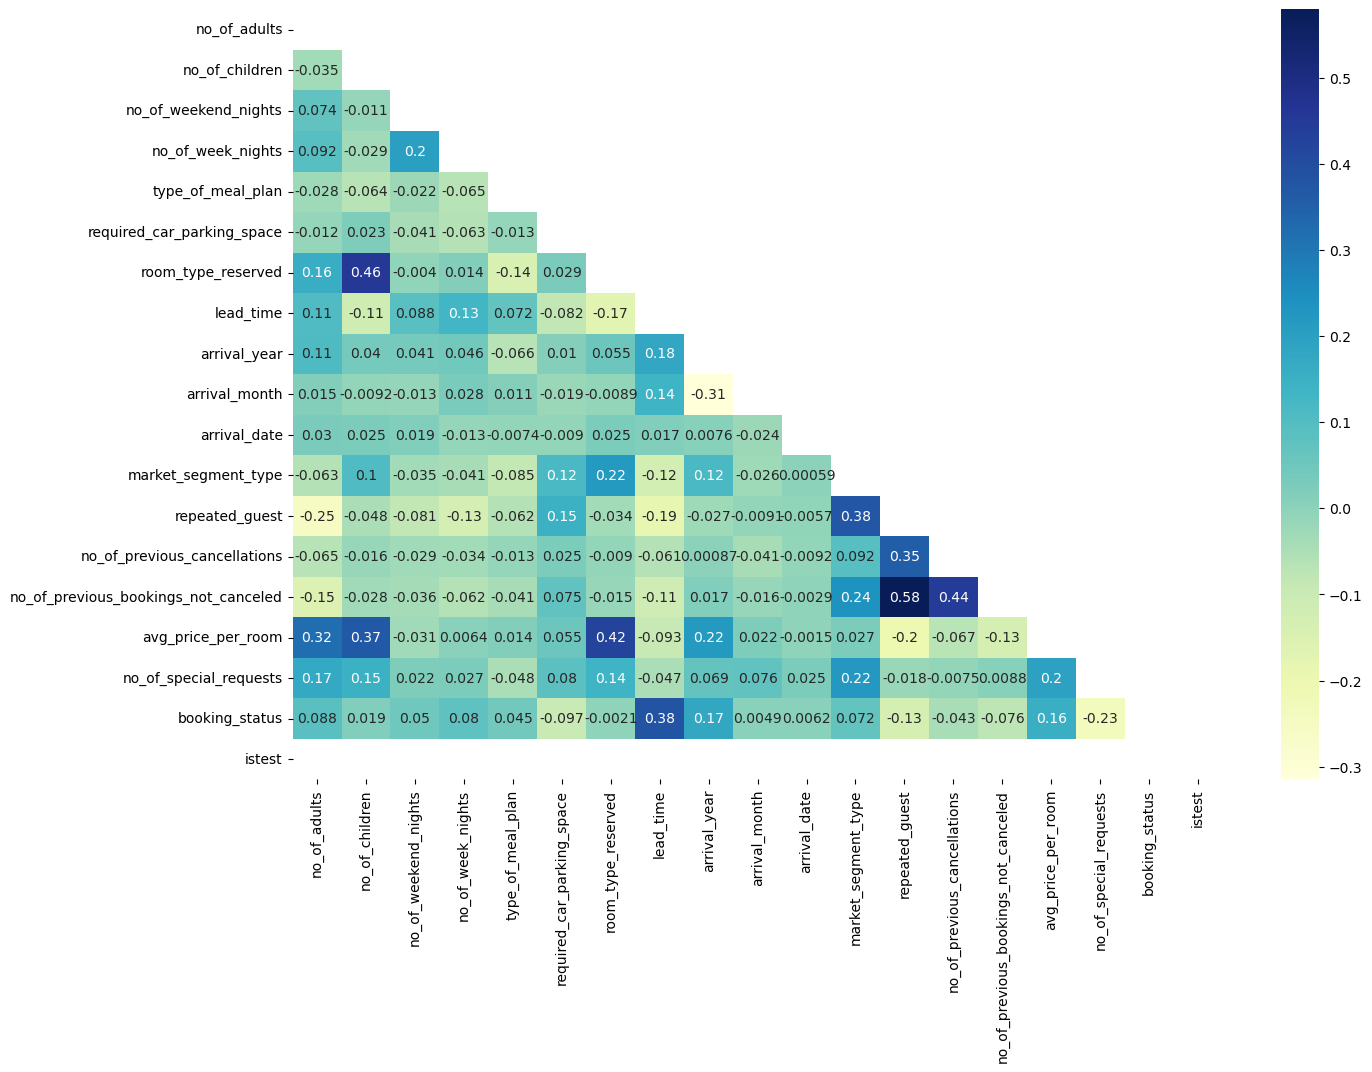

In [9]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
corr = total_train.corr()
matrix = np.triu(corr)
sns.heatmap(corr, annot=True, mask = matrix,cmap="YlGnBu")
plt.show()

#### For this dataset, we seem to have various features that seem to have a meaningful correlation with the target variable, such as 'lead_time', 'arrival_year' and 'avg_price_per_room'
#### Maybe we can try to feature engineer some new variables with these features

## 2.3 Feature Engineering

In [10]:
if FEATURE_ENGINEERING:
    total_train['istest'] = 0
    test['istest'] = 1
    raw = pd.concat([total_train, test])

    raw['lead_time_avg_price_per_room'] = raw['lead_time'] * raw['avg_price_per_room']
    
    total_train = raw[raw['istest'] == 0]
    test = raw[raw['istest'] == 1]
    
    features.extend(['lead_time_avg_price_per_room'])

## 2.4 Scaling

#### Let us create a scaled dataset for sensitive models

In [11]:
def scale_features(train, test, features):
    scalar = StandardScaler()
    train_copy = train.copy()
    test_copy = test.copy()
    train_copy[features] = scalar.fit_transform(train_copy[features])
    test_copy[features] = scalar.transform(test_copy[features])
    return train_copy, test_copy

total_train_scaled, test_scaled = scale_features(total_train, test, features)

# 3. Modeling

In [12]:
X, y = total_train[features], total_train[target]
X_scaled, y_scaled = total_train_scaled[features], total_train_scaled[target]

## 3.1 XGBClassifier

In [13]:
xgb = XGBClassifier(verbosity=0)
score_arr = []

skf = StratifiedKFold(n_splits=5)
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    x_train_fold, y_train_fold = X.iloc[train_index], y.iloc[train_index]
    x_test_fold, y_test_fold = X.iloc[test_index], y.iloc[test_index]
    xgb.fit(x_train_fold, y_train_fold)
    score = roc_auc_score(y_test_fold, xgb.predict_proba(x_test_fold)[:, 1])
    print("-------------")
    print('iteration {}'.format(i+1))
    print(score)
    score_arr.append(score)
    
print(f"\naverage score is {np.mean(score_arr)}")

-------------
iteration 1
0.8920355516753571
-------------
iteration 2
0.8985630693714455
-------------
iteration 3
0.8979065900720656
-------------
iteration 4
0.8973977824183472
-------------
iteration 5
0.9070942194993858

average score is 0.8985994426073203


## 3.2 LGBMClassifier

In [14]:
lgbm = LGBMClassifier(verbose = -1)
score_arr = []

skf = StratifiedKFold(n_splits=5)
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    x_train_fold, y_train_fold = X.iloc[train_index], y.iloc[train_index]
    x_test_fold, y_test_fold = X.iloc[test_index], y.iloc[test_index]
    lgbm.fit(x_train_fold, y_train_fold)
    score = roc_auc_score(y_test_fold, lgbm.predict_proba(x_test_fold)[:, 1])
    print("-------------")
    print('iteration {}'.format(i+1))
    print(score)
    score_arr.append(score)
    
print(f"\naverage score is {np.mean(score_arr)}")

-------------
iteration 1
0.889881036810006
-------------
iteration 2
0.8950397906892799
-------------
iteration 3
0.8951609045966239
-------------
iteration 4
0.8961338416503623
-------------
iteration 5
0.9047802517777537

average score is 0.896199165104805


## 3.3 Random Forest

In [15]:
rf = RandomForestClassifier()
score_arr = []

skf = StratifiedKFold(n_splits=5)
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    x_train_fold, y_train_fold = X.iloc[train_index], y.iloc[train_index]
    x_test_fold, y_test_fold = X.iloc[test_index], y.iloc[test_index]
    rf.fit(x_train_fold, y_train_fold)
    score = roc_auc_score(y_test_fold, rf.predict_proba(x_test_fold)[:, 1])
    print("-------------")
    print('iteration {}'.format(i+1))
    print(score)
    score_arr.append(score)
    
print(f"\naverage score is {np.mean(score_arr)}")

-------------
iteration 1
0.8699071369664072
-------------
iteration 2
0.8748800866213143
-------------
iteration 3
0.8784476778308877
-------------
iteration 4
0.8733385942645185
-------------
iteration 5
0.8789697098617925

average score is 0.875108641108984


## 3.4 Logistic Regression

In [16]:
lr = LogisticRegression()
score_arr = []

skf = StratifiedKFold(n_splits=5)
for i, (train_index, test_index) in enumerate(skf.split(X_scaled, y_scaled)):
    x_train_fold, y_train_fold = X_scaled.iloc[train_index], y_scaled.iloc[train_index]
    x_test_fold, y_test_fold = X_scaled.iloc[test_index], y_scaled.iloc[test_index]
    lr.fit(x_train_fold, y_train_fold)
    score = roc_auc_score(y_test_fold, lr.predict_proba(x_test_fold)[:, 1])
    print("-------------")
    print('iteration {}'.format(i+1))
    print(score)
    score_arr.append(score)
    
print(f"\naverage score is {np.mean(score_arr)}")

-------------
iteration 1
0.8328865227204372
-------------
iteration 2
0.8371328096030282
-------------
iteration 3
0.8420883794545684
-------------
iteration 4
0.8450143388481673
-------------
iteration 5
0.8451790716654344

average score is 0.840460224458327


## 3.5 GaussianNB

In [17]:
nb = GaussianNB()
score_arr = []

skf = StratifiedKFold(n_splits=5)
for i, (train_index, test_index) in enumerate(skf.split(X_scaled, y_scaled)):
    x_train_fold, y_train_fold = X_scaled.iloc[train_index], y_scaled.iloc[train_index]
    x_test_fold, y_test_fold = X_scaled.iloc[test_index], y_scaled.iloc[test_index]
    nb.fit(x_train_fold, y_train_fold)
    score = roc_auc_score(y_test_fold, nb.predict_proba(x_test_fold)[:, 1])
    print("-------------")
    print('iteration {}'.format(i+1))
    print(score)
    score_arr.append(score)
    
print(f"\naverage score is {np.mean(score_arr)}")

-------------
iteration 1
0.8020116862353913
-------------
iteration 2
0.8023214926168964
-------------
iteration 3
0.808127691388274
-------------
iteration 4
0.8146955388673908
-------------
iteration 5
0.815295011432863

average score is 0.808490284108163


## 3.6 Voting Classifier

In [18]:
vc = VotingClassifier(estimators=[('xgb', xgb), ('lgbm', lgbm), ('rf', rf)], voting='soft')
score_arr = []

skf = StratifiedKFold(n_splits=5)
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    x_train_fold, y_train_fold = X.iloc[train_index], y.iloc[train_index]
    x_test_fold, y_test_fold = X.iloc[test_index], y.iloc[test_index]
    vc.fit(x_train_fold, y_train_fold)
    score = roc_auc_score(y_test_fold, vc.predict_proba(x_test_fold)[:, 1])
    print("-------------")
    print('iteration {}'.format(i+1))
    print(score)
    score_arr.append(score)
    
print(f"\naverage score is {np.mean(score_arr)}")

-------------
iteration 1
0.8907266540881851
-------------
iteration 2
0.8963247707316988
-------------
iteration 3
0.8970343434729354
-------------
iteration 4
0.8960343216047815
-------------
iteration 5
0.9057697705436877

average score is 0.8971779720882577


# 4. Hyperparameter Tuning

## 4.1 XGBClassifier

In [19]:
def objective(trial):   
    params_xgb = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0),
        "tree_method":"gpu_hist",
        'random_state': RANDOM,
        }

    xgb_tuned = XGBClassifier(**params_xgb)
    score_arr = []

    skf = StratifiedKFold(n_splits=5)
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        x_train_fold, y_train_fold = X.iloc[train_index], y.iloc[train_index]
        x_test_fold, y_test_fold = X.iloc[test_index], y.iloc[test_index]
        xgb_tuned.fit(x_train_fold, y_train_fold)
        score_arr.append(roc_auc_score(y_test_fold, xgb_tuned.predict_proba(x_test_fold)[:, 1]))
        
    return np.mean(score_arr)

if TUNE:
    xgb_tuning = optuna.create_study(direction='maximize', sampler = TPESampler())
    xgb_tuning.optimize(func=objective, n_trials=100)
    print(xgb_tuning.best_params)

## 4.2 LGBMClassifier

In [20]:
def objective(trial): 
    
    params_lgbm = {
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss']),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 200),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 1.0),
        'random_state': RANDOM,
        'device': 'gpu'
    }

    lgbm_tuned = LGBMClassifier(**params_lgbm)
    score_arr = []

    skf = StratifiedKFold(n_splits=5)
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        x_train_fold, y_train_fold = X.iloc[train_index], y.iloc[train_index]
        x_test_fold, y_test_fold = X.iloc[test_index], y.iloc[test_index]
        lgbm_tuned.fit(x_train_fold, y_train_fold)
        score_arr.append(roc_auc_score(y_test_fold, lgbm_tuned.predict_proba(x_test_fold)[:, 1]))
    
    return np.mean(score_arr)

if TUNE:
    lgbm_tuning = optuna.create_study(direction='maximize', sampler = TPESampler())
    lgbm_tuning.optimize(func=objective, n_trials=100)
    print(lgbm_tuning.best_params)

## 4.3 Random Forest Classifier

In [21]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
if TUNE:
    rf_tuned = RandomForestClassifier()
    rf_random = RandomizedSearchCV(estimator = rf_tuned, 
                                   param_distributions = random_grid, 
                                   n_iter = 100, 
                                   cv = 5, 
                                   verbose=1, 
                                   random_state=RANDOM, 
                                   n_jobs = -1)
    rf_random.fit(X, y)
    print(rf_random.best_params_)

# 5. Tuned Modeling

## 5.1 Tuned XGBClassifier

In [22]:
xgb_tuned = {'max_depth': 7, 
             'learning_rate': 0.06990369031205824, 
             'n_estimators': 458, 
             'min_child_weight': 4, 
             'gamma': 0.09749875478177321, 
             'subsample': 0.8235591553981333, 
             'colsample_bytree': 0.4273524759947413, 
             'reg_alpha': 0.4441912206474806, 
             'reg_lambda': 0.924686819948825}

if not BASIC:
    xgb = XGBClassifier(**xgb_tuned)
    score_arr = []
    skf = StratifiedKFold(n_splits=5)
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        x_train_fold, y_train_fold = X.iloc[train_index], y.iloc[train_index]
        x_test_fold, y_test_fold = X.iloc[test_index], y.iloc[test_index]
        xgb.fit(x_train_fold, y_train_fold)
        score = roc_auc_score(y_test_fold, xgb.predict_proba(x_test_fold)[:, 1])
        print("-------------")
        print('iteration {}'.format(i+1))
        print(score)
        score_arr.append(score)

    print(f"\naverage score is {np.mean(score_arr)}")

-------------
iteration 1
0.8965876285287606
-------------
iteration 2
0.9038181809234531
-------------
iteration 3
0.9027643579963289
-------------
iteration 4
0.9012095449205257
-------------
iteration 5
0.9093381612980367

average score is 0.9027435747334209


## 5.2 Tuned LGBMClassifier

In [23]:
lgbm_tuned = {'boosting_type': 'gbdt', 
              'num_leaves': 35, 
              'learning_rate': 0.08164094732597456, 
              'n_estimators': 563, 'max_depth': 7, 
              'min_child_samples': 107, 
              'subsample': 0.46464475982259096, 
              'colsample_bytree': 0.4504115191715242, 
              'reg_alpha': 0.6737592697757495, 
              'reg_lambda': 0.9369236860499441}


if not BASIC:
    lgbm = LGBMClassifier(**lgbm_tuned)
    score_arr = []
    skf = StratifiedKFold(n_splits=5)
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        x_train_fold, y_train_fold = X.iloc[train_index], y.iloc[train_index]
        x_test_fold, y_test_fold = X.iloc[test_index], y.iloc[test_index]
        lgbm.fit(x_train_fold, y_train_fold)
        score = roc_auc_score(y_test_fold, lgbm.predict_proba(x_test_fold)[:, 1])
        print("-------------")
        print('iteration {}'.format(i+1))
        print(score)
        score_arr.append(score)

    print(f"\naverage score is {np.mean(score_arr)}")

-------------
iteration 1
0.8966847098790967
-------------
iteration 2
0.9033934183548378
-------------
iteration 3
0.9007568358756688
-------------
iteration 4
0.9019065109415596
-------------
iteration 5
0.9076009393823763

average score is 0.9020684828867079


## 5.3 Tuned Random Forest Classifier

In [24]:
rf_tuned = {'n_estimators': 1600, 
            'min_samples_split': 10, 
            'min_samples_leaf': 2, 
            'max_features': 'auto', 
            'max_depth': None, 
            'bootstrap': True}

if not BASIC:
    rf = RandomForestClassifier(**rf_tuned)
    score_arr = []
    skf = StratifiedKFold(n_splits=5)
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        x_train_fold, y_train_fold = X.iloc[train_index], y.iloc[train_index]
        x_test_fold, y_test_fold = X.iloc[test_index], y.iloc[test_index]
        rf.fit(x_train_fold, y_train_fold)
        score = roc_auc_score(y_test_fold, rf.predict_proba(x_test_fold)[:, 1])
        print("-------------")
        print('iteration {}'.format(i+1))
        print(score)
        score_arr.append(score)

    print(f"\naverage score is {np.mean(score_arr)}")

-------------
iteration 1
0.8867316461610206
-------------
iteration 2
0.8928583007413061
-------------
iteration 3
0.8933080702555679
-------------
iteration 4
0.8921867680753011
-------------
iteration 5
0.8970327428911565

average score is 0.8924235056248705


## 5.4 Tuned Voting Classifier

In [25]:
vc = VotingClassifier(estimators=[('xgb', xgb), ('lgbm', lgbm), ('rf', rf)], voting='soft')
score_arr = []
if not BASIC:
    skf = StratifiedKFold(n_splits=5)
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        x_train_fold, y_train_fold = X.iloc[train_index], y.iloc[train_index]
        x_test_fold, y_test_fold = X.iloc[test_index], y.iloc[test_index]
        vc.fit(x_train_fold, y_train_fold)
        score = roc_auc_score(y_test_fold, vc.predict_proba(x_test_fold)[:, 1])
        print("-------------")
        print('iteration {}'.format(i+1))
        print(score)
        score_arr.append(score)
    
print(f"\naverage score is {np.mean(score_arr)}")

-------------
iteration 1
0.8958871809775844
-------------
iteration 2
0.9026980727307569
-------------
iteration 3
0.901552778761272
-------------
iteration 4
0.901040939868758
-------------
iteration 5
0.9086646096295451

average score is 0.9019687163935833


# 6. Result Analysis

## 6.1 Feature Importances

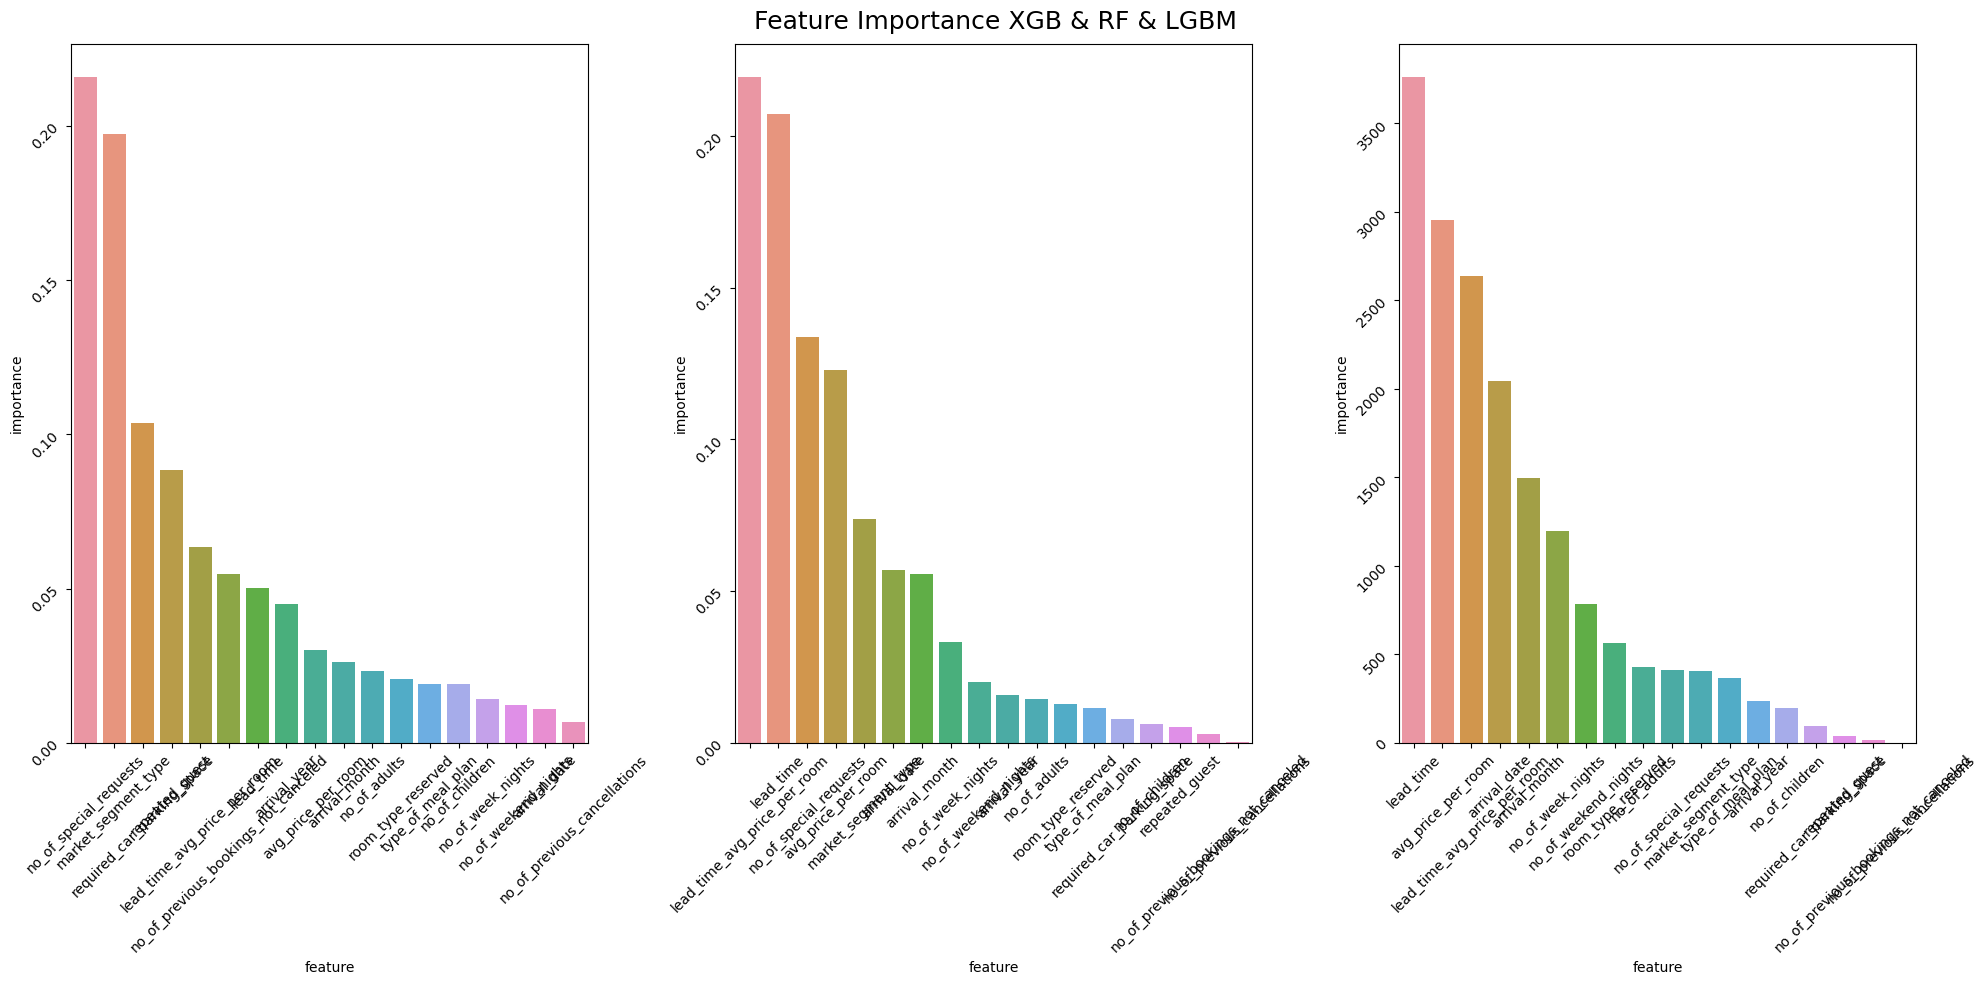

In [26]:
model1, model2, model3 = xgb, rf, lgbm

fe =sorted(list(zip(model1.feature_names_in_,model1.feature_importances_)),key= lambda x: x[1], reverse=True)
df_fe = pd.DataFrame(fe,columns= ['feature', 'importance'])
fe =sorted(list(zip(model2.feature_names_in_,model2.feature_importances_)),key= lambda x: x[1], reverse=True)
df_fe2 = pd.DataFrame(fe,columns= ['feature', 'importance'])
fe =sorted(list(zip(model3.feature_name_,model3.feature_importances_)),key= lambda x: x[1], reverse=True)
df_fe3 = pd.DataFrame(fe,columns= ['feature', 'importance'])

fig, axs = plt.subplots(1, 3, figsize=(20,10))
sns.barplot(data = df_fe, x= 'feature', y= 'importance',ax=axs[0])
axs[0].tick_params(labelrotation=45)
sns.barplot(data = df_fe2, x= 'feature', y= 'importance',ax=axs[1])
axs[1].tick_params(labelrotation=45)
sns.barplot(data = df_fe3, x= 'feature', y= 'importance',ax=axs[2])
axs[2].tick_params(labelrotation=45)

plt.suptitle("Feature Importance XGB & RF & LGBM",size=18)
plt.tight_layout()
plt.show()

## 6.2 Confusion Matrix

# 7. Submission

In [27]:
test.drop(['booking_status', 'istest'], axis=1, inplace=True)


vc.fit(X,y)
vc_pred = vc.predict(test)
sub['booking_status'] = vc_pred
sub.to_csv('submission.csv', index=False)
sub.head()

,id,booking_status
0,42100,0.0
1,42101,0.0
2,42102,0.0
3,42103,0.0
4,42104,0.0
